In [56]:
import pandas as pd
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from numpy import abs, array, triu, ones_like
from math import sqrt
import pickle

### Get historical data from the NASA POWER PROJECT API
##### Data is collected from: 1st Jan 2012 through 19th March 2022

In [ ]:
url = "https://power.larc.nasa.gov/api/temporal/daily/point?start=20000101&end=20220101&latitude=-1.5177&longitude=37.2634&parameters=T2M,PS,WS10M,QV2M,PRECTOTCORR&community=AG&format=csv"

csv_path = keras.utils.get_file(fname="machakos-county-2000-2022.csv", origin=url)

In [ ]:
def parse_date(x):
    return datetime.strptime(x, '%Y %j')

In [ ]:
# Skip the CSV description rows
df = pd.read_csv(csv_path, skiprows=13, parse_dates={'date': ['YEAR', 'DOY']}, date_parser=parse_date, skipinitialspace=True, index_col=0)

In [ ]:
df.tail()

In [ ]:
# Get column names
df.columns

In [ ]:
# Remove empty values
indexes_to_drop = df.index[df['T2M'] == -999.00]
df.drop(indexes_to_drop, inplace=True)

In [ ]:
# Check for outliers
sns.boxplot(x=df['PRECTOTCORR'])

In [ ]:
# Visualize trends
df.plot.line(figsize=(12, 4), subplots=True)
# plt.savefig("Sub plot", dpi=1200)

### Check for multicollinearity among predictor variables

In [ ]:
correlation = df.iloc[:, :-1].corr()

In [ ]:
# Generate a mask for upper traingle
#
mask = triu(ones_like(correlation, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation, annot=True, mask=mask, cmap=cmap)

In [ ]:
# split multivariate sequence into samples
def to_supervised(sequences, n_steps_back, n_steps_future):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of the pattern
        end_index = i + n_steps_back
        out_end_index = end_index + n_steps_future - 1
        # check if index is out of bound
        if out_end_index > len(sequences) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_index, :-1], sequences[end_index-1:out_end_index, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [ ]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))

df_scaled = scaler.fit_transform(df)

In [ ]:
# X, y = to_supervised(df_scaled,n_steps_back=60,n_steps_future=30)

In [ ]:
# print('Y shape', y.shape)
# print('X shape', X.shape)
# print('DF Scaled', df_scaled.shape)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Problem Framing
#### Given the past 60 days historical weather data, forecast the rainfall for the next 3,5,7,30 days

In [ ]:

def build_model(X, y):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False, recurrent_dropout=0.2, unroll=True))
    model.add(Dropout(0.2))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

In [ ]:
training_history = []
models = []
forecast_days = [3,5,7,30]
y_preds = []
train_test_data = []

In [ ]:
for index, future_days in enumerate(forecast_days):
    # Convert data to supervised
    X, y = to_supervised(df_scaled, n_steps_back=60, n_steps_future=future_days)
    # split to train test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    # Append data
    train_test_data.append((x_train, x_test, y_train, y_test))
    # Build model
    model = build_model(x_train, y_train)
    # Fit model
    history = model.fit(x_train, y_train, epochs=60, batch_size=64, validation_split=0.3, verbose=1)
    # Append histories
    training_history.append(history)
    # Append model
    models.append(model)

In [23]:
for index, model in enumerate(models):
    model.save(f'rainfall-model-{forecast_days[index]}-day')
    

INFO:tensorflow:Assets written to: rainfall-model-3-day\assets


INFO:tensorflow:Assets written to: rainfall-model-3-day\assets


INFO:tensorflow:Assets written to: rainfall-model-5-day\assets


INFO:tensorflow:Assets written to: rainfall-model-5-day\assets


INFO:tensorflow:Assets written to: rainfall-model-7-day\assets


INFO:tensorflow:Assets written to: rainfall-model-7-day\assets


INFO:tensorflow:Assets written to: rainfall-model-30-day\assets


INFO:tensorflow:Assets written to: rainfall-model-30-day\assets


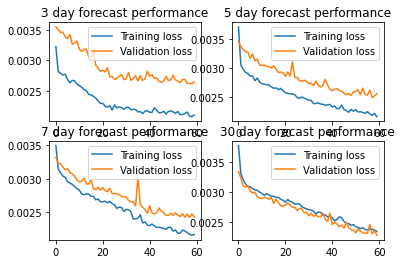

In [59]:
for i , history in enumerate(training_history):
    plt.subplot(2, 2, i+1)
    plt.title(f'{forecast_days[i]} day forecast performance')
    plt.plot(history.history['loss'], label='Training loss' )
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()

In [31]:
from numpy import zeros

In [32]:
def reverse_y_scaler(data):
    data = data.ravel() # convert from 2D array into 1D array
    # create a new numpy array
    shape = (data.shape[0], 5)
    n_array = zeros(shape)
    n_array[:, -1] = data
    return n_array

In [45]:
type(train_test_data)

list

## Evaluation Metric
Evaluate each time step separately in order to:
* Comment on the skill at a particular lead time (1 day vs 3 day)
* Contrast models based on their skills at different lead times (models good at +1 day vs models good at days +5)

In [57]:
model_performance = {}
inverse_y_test_pred = []
# Perform fit for each model
for (index, model) in enumerate(models):
    X_test = train_test_data.__getitem__(index)[0]
    y_test = train_test_data.__getitem__(index)[2]
    #  get prediction
    yhat = model.predict(X_test, verbose=0)

    print(y_test.shape)
    print(yhat.shape)

    inv_yhat = scaler.inverse_transform(reverse_y_scaler(yhat))[:, -1]
    inv_y_test = scaler.inverse_transform(reverse_y_scaler(y_test))[:, -1]
    inverse_y_test_pred.append((inv_y_test, inv_yhat))
    mse = mean_squared_error(inv_y_test, inv_yhat)
    rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat))
    mae = mean_absolute_error(inv_y_test, inv_yhat)

    model_performance[f'{forecast_days[index]} day'] = {
        'mean_squared_error': mse,
        'root_mean_squared_error': rmse,
        'mean_absolute_error': mae,
    }
    


(6380, 3)
(6380, 3)
(6378, 5)
(6378, 5)
(6376, 7)
(6376, 7)
(6358, 30)
(6358, 30)


In [55]:
[print(key,':',value) for key, value in model_performance.items()]

3 day : {'mean_squared_error': 5.88795435530309, 'root_mean_squared_error': 2.426510736696438, 'mean_absolute_error': 1.3253998950575125}
5 day : {'mean_squared_error': 6.038338120792621, 'root_mean_squared_error': 2.457303017699002, 'mean_absolute_error': 1.2958612204379842}
7 day : {'mean_squared_error': 5.830175799812003, 'root_mean_squared_error': 2.414575697676924, 'mean_absolute_error': 1.2600699348909965}
30 day : {'mean_squared_error': 6.011621129517505, 'root_mean_squared_error': 2.451860748394473, 'mean_absolute_error': 1.3729330106252258}


[None, None, None, None]

In [ ]:
x_t = list(range(1,101))
plt.plot(x_t, inv_ytest[0:100], color='g', label='actual')
plt.plot(x_t, inv_yhat[0:100], color='r', label='predicted')
plt.title('Actual vs predicted 100 day span')
plt.xlabel('Day')
plt.ylabel('Rainfall in mm/day')
plt.legend()
plt.show()


In [ ]:
df_scaled

In [60]:
pickle.dump(scaler, open('scaler.sav', 'wb'))